# Image Processing

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import random
import matplotlib.pyplot as plt
import numpy as np
from torch import optim
from torch.optim import lr_scheduler
import torchvision.models as models

# ----------------------------------------------------------------------------------------------
# Augmentation
# Define data augmentation transforms
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    # transforms.RandomRotation(90),  # Randomly rotate the image up to 30 degrees
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Adjust color
    # transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random affine transformation
    # transforms.RandomPerspective(),  # Random perspective transformation
    # transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Random resized crop
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize the image to RGB
])

# Define the data loaders
train_dataset = ImageFolder(root='/local/data1/honzh073/data/hospital_43_data/train', transform=transform)
validation_dataset = ImageFolder(root='/local/data1/honzh073/data/hospital_43_data/val', transform=transform)
test_dataset = ImageFolder(root='/local/data1/honzh073/data/hospital_43_data/test', transform=transform)


batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

# ----------------------------------------------------------------------------------------------
# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available!")
    device = torch.device("cuda:0")  # Use GPU 0
else:
    print("CUDA is not available.")
    device = torch.device("cpu")
# ----------------------------------------------------------------------------------------------
print('done!')


CUDA is available!
done!


# Plot 8 bit Images

Image 1 Path: /local/data1/honzh073/data/hospital_43_data/val/NFF/patient_GXVLZPGVLG/patient_GXVLZPGVLG_hospital_43_NFF_image_3.png
Image 2 Path: /local/data1/honzh073/data/hospital_43_data/val/NFF/patient_YKVUJXHELG/patient_YKVUJXHELG_hospital_43_NFF_image_3.png
Image 3 Path: /local/data1/honzh073/data/hospital_43_data/val/NFF/patient_YNULWKTZNL/patient_YNULWKTZNL_hospital_43_NFF_image_4.png
Image 4 Path: /local/data1/honzh073/data/hospital_43_data/val/NFF/patient_HGGEYYVSEJ/patient_HGGEYYVSEJ_hospital_43_NFF_image_1.png
Image 5 Path: /local/data1/honzh073/data/hospital_43_data/val/NFF/patient_HGGEYYVSEJ/patient_HGGEYYVSEJ_hospital_43_NFF_image_5.png


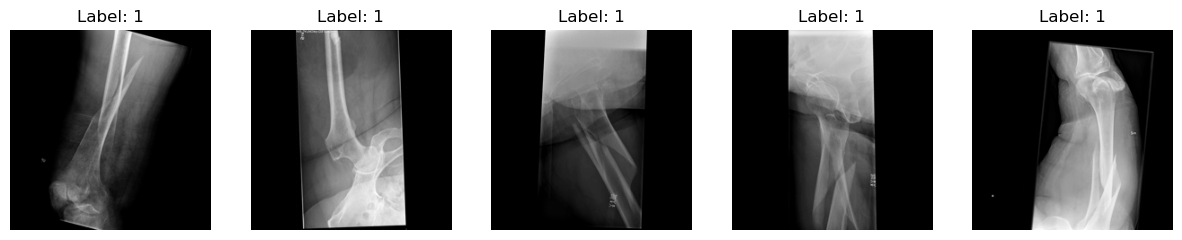

In [2]:
# Get some random indices from the validation dataset
random_indices = np.random.choice(len(validation_dataset), 5, replace=False)

# Print image file paths
for i, idx in enumerate(random_indices):
    filename = validation_dataset.samples[idx][0]  # Get the filename
    print(f"Image {i + 1} Path: {filename}")

# Plot images (transformed) with truncated names
plt.figure(figsize=(15, 5))
for i, idx in enumerate(random_indices):
    image, label = validation_dataset[idx]  # Use validation_dataset directly
    filename = validation_dataset.samples[idx][0]  # Get the filename
    truncated_filename = filename.split('/')[-1][:15]  # Extract the last part and truncate to 15 characters
    plt.subplot(1, 5, i + 1)
    plt.title(f"Label: {label}")
    plt.imshow(image[0], cmap='gray')  # Single-channel (grayscale)
    plt.axis('off')
plt.show()


# Class weights of Training Dataset

In [3]:
# ---------------------------------------------------------------------------------

# aff and nff numbers in training dataset
train_aff_count = sum(1 for _, label in train_dataset if label == 0)  # 0 AFF
train_nff_count = sum(1 for _, label in train_dataset if label == 1)  # 1 NFF

# ---------------------------------------------------------------------------------
# Calculate class weights
n_aff_train = train_aff_count
n_nff_train = train_nff_count

class_weight_aff = 1 / (2 * (n_aff_train / (n_aff_train + n_nff_train)))
class_weight_nff = 1 / (2 * (n_nff_train / (n_aff_train + n_nff_train)))

print(f"Class Weight for AFF (0): {class_weight_aff:.4f}")
print(f"Class Weight for NFF (1): {class_weight_nff:.4f}")


Class Weight for AFF (0): 1.6667
Class Weight for NFF (1): 0.7143


# ResNet152
# 80% Training, 10% Validation, and 10% Test
# Test Performance

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt

# Settings
lr = 0.0001
step_size = 10
gamma = 0.1

# Class weights
class_weights = [class_weight_aff, class_weight_nff]
class_weights = torch.Tensor(class_weights).to(device)

# ResNet152
model = models.resnet152(pretrained=True)
# Modify the final fully connected (fc) layer to match the number of classes in your dataset
num_classes = 2  # Assuming 2 classes (you can adjust this)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# Load trained model's weights
checkpoint = torch.load('/local/data1/honzh073/saved_model/fracatlas.pth')
model.load_state_dict(checkpoint)  # Load the model's state_dict directly

# Loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)
criterion = criterion.to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# Training (loss and accuracy)
train_losses = []
validation_losses = []
train_accuracies = []
validation_accuracies = []

num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    correct_train = 0
    total_train = 0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_accuracy = 100 * correct_train / total_train
    
    model.eval()
    correct_validation = 0
    total_validation = 0
    validation_loss = 0
    
    with torch.no_grad():
        for images, labels in validation_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            _, predicted = torch.max(outputs.data, 1)
            total_validation += labels.size(0)
            correct_validation += (predicted == labels).sum().item()
            validation_loss += loss.item()
    
    validation_accuracy = 100 * correct_validation / total_validation
    validation_loss /= len(validation_loader)
    
    train_losses.append(loss.item())
    validation_losses.append(validation_loss)
    train_accuracies.append(train_accuracy)
    validation_accuracies.append(validation_accuracy)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item():.4f}, Validation Loss: {validation_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Validation Acc: {validation_accuracy:.2f}%")
    
    scheduler.step()  # Step the learning rate scheduler

# Plot loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

# Test dataset performance
model.eval()
correct_test = 0
total_test = 0
test_loss = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
        test_loss += loss.item()

test_accuracy = 100 * correct_test / total_test
test_loss /= len(test_loader)

print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%")


/local/data1/honzh073/anaconda3/envs/myenv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/local/data1/honzh073/anaconda3/envs/myenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50, Train Loss: 0.4490, Validation Loss: 0.7982, Train Acc: 57.89%, Validation Acc: 46.43%
Epoch 2/50, Train Loss: 0.4545, Validation Loss: 0.6801, Train Acc: 68.42%, Validation Acc: 60.71%
Epoch 3/50, Train Loss: 0.5260, Validation Loss: 0.5707, Train Acc: 71.05%, Validation Acc: 71.43%
Epoch 4/50, Train Loss: 0.6551, Validation Loss: 0.6200, Train Acc: 77.37%, Validation Acc: 75.00%
Epoch 5/50, Train Loss: 0.5683, Validation Loss: 0.5356, Train Acc: 80.53%, Validation Acc: 75.00%
Epoch 6/50, Train Loss: 0.7911, Validation Loss: 0.6212, Train Acc: 85.26%, Validation Acc: 75.00%
Epoch 7/50, Train Loss: 0.6277, Validation Loss: 0.5102, Train Acc: 90.53%, Validation Acc: 82.14%
Epoch 8/50, Train Loss: 0.3807, Validation Loss: 0.3422, Train Acc: 87.37%, Validation Acc: 89.29%
Epoch 9/50, Train Loss: 0.5443, Validation Loss: 0.4419, Train Acc: 91.05%, Validation Acc: 82.14%
Epoch 10/50, Train Loss: 0.4090, Validation Loss: 0.4085, Train Acc: 91.58%, Validation Acc: 75.00%
Epoch 11/

Test Loss: 0.5379, Test Acc: 77.78%


In [33]:

# Test dataset performance
model.eval()
correct_test = 0
total_test = 0
test_loss = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
        test_loss += loss.item()

test_accuracy = 100 * correct_test / total_test
test_loss /= len(test_loader)

print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%")

Test Loss: 0.6291, Test Acc: 74.07%


In [6]:
from sklearn.metrics import confusion_matrix, classification_report

# 获取原始数据集的类别标签
original_classes = test_loader.dataset.classes

# 计算混淆矩阵和分类报告
with torch.no_grad():
    all_predictions = []
    all_labels = []

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 生成混淆矩阵
conf_matrix = confusion_matrix(all_labels, all_predictions)

# 计算 Precision、Recall、F1 Score
classification_rep = classification_report(all_labels, all_predictions, target_names=original_classes)

print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_rep)
# 85 AFF 350 NFF

Confusion Matrix:
[[ 6  2]
 [ 7 12]]
Classification Report:
              precision    recall  f1-score   support

         AFF       0.46      0.75      0.57         8
         NFF       0.86      0.63      0.73        19

    accuracy                           0.67        27
   macro avg       0.66      0.69      0.65        27
weighted avg       0.74      0.67      0.68        27



# Save model

In [7]:
# Save the trained VGG model
# torch.save(model.state_dict(), 'transfer_patient_level_resnet152.pth')


# Clean GPU memory

In [8]:
torch.cuda.empty_cache()


# VGG19